In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [3]:
# Define the file path to the dataset
file_path = "/kaggle/input/new-york-city-transport-statistics/mta_1706.csv"

# Load the CSV file, skipping problematic lines that may cause errors
df = pd.read_csv(file_path, on_bad_lines="skip")

# Display the first few rows to verify that the data is loaded correctly
display(df.head())

# Show dataset information, including column types and missing values
display(df.info())

,RecordedAtTime,DirectionRef,PublishedLineName,OriginName,OriginLat,OriginLong,DestinationName,DestinationLat,DestinationLong,VehicleRef,VehicleLocation.Latitude,VehicleLocation.Longitude,NextStopPointName,ArrivalProximityText,DistanceFromStop,ExpectedArrivalTime,ScheduledArrivalTime
0,2017-06-01 00:03:34,0,B8,4 AV/95 ST,40.616104,-74.031143,BROWNSVILLE ROCKAWAY AV,40.656048,-73.907379,NYCT_430,40.635170,-73.960803,FOSTER AV/E 18 ST,approaching,76.0,2017-06-01 00:03:59,24:06:14
1,2017-06-01 00:03:43,1,S61,ST GEORGE FERRY/S61 & S91,40.643169,-74.073494,S I MALL YUKON AV,40.575935,-74.167686,NYCT_8263,40.590802,-74.158340,MERRYMOUNT ST/TRAVIS AV,approaching,62.0,2017-06-01 00:03:56,23:58:02
2,2017-06-01 00:03:49,0,Bx10,E 206 ST/BAINBRIDGE AV,40.875008,-73.880142,RIVERDALE 263 ST,40.912376,-73.902534,NYCT_4223,40.886010,-73.912647,HENRY HUDSON PKY E/W 235 ST,at stop,5.0,2017-06-01 00:03:56,24:00:53
3,2017-06-01 00:03:31,0,Q5,TEARDROP/LAYOVER,40.701748,-73.802399,ROSEDALE LIRR STA via MERRICK,40.666012,-73.735939,NYCT_8422,40.668002,-73.729348,HOOK CREEK BL/SUNRISE HY,< 1 stop away,267.0,2017-06-01 00:04:03,24:03:00
4,2017-06-01 00:03:22,1,Bx1,RIVERDALE AV/W 231 ST,40.881187,-73.909340,MOTT HAVEN 136 ST via CONCOURSE,40.809654,-73.928360,NYCT_4710,40.868134,-73.893032,GRAND CONCOURSE/E 196 ST,at stop,11.0,2017-06-01 00:03:56,23:59:38


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6730436 entries, 0 to 6730435
Data columns (total 17 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   RecordedAtTime             object 
 1   DirectionRef               int64  
 2   PublishedLineName          object 
 3   OriginName                 object 
 4   OriginLat                  float64
 5   OriginLong                 float64
 6   DestinationName            object 
 7   DestinationLat             float64
 8   DestinationLong            float64
 9   VehicleRef                 object 
 10  VehicleLocation.Latitude   float64
 11  VehicleLocation.Longitude  float64
 12  NextStopPointName          object 
 13  ArrivalProximityText       object 
 14  DistanceFromStop           float64
 15  ExpectedArrivalTime        object 
 16  ScheduledArrivalTime       object 
dtypes: float64(7), int64(1), object(9)
memory usage: 872.9+ MB


None

In [4]:
# Handle missing values
missing_values = df.isnull().sum()
print("\nMissing values:\n", missing_values[missing_values > 0])

# Check for duplicate rows
duplicates = df.duplicated().sum()
print("\nDuplicate rows in the dataset:", duplicates)

# Drop rows with NaN values if they are few, otherwise consider filling with mean values
df.dropna(inplace=True)


Missing values:
 OriginName               63156
OriginLat                63156
OriginLong               63156
DestinationLat           10346
DestinationLong          10346
NextStopPointName         7002
ArrivalProximityText      7002
DistanceFromStop          7002
ExpectedArrivalTime     872302
ScheduledArrivalTime    172333
dtype: int64

Duplicate rows in the dataset: 0


In [5]:
# Convert ExpectedArrivalTime to datetime
df['ExpectedArrivalTime'] = pd.to_datetime(df['ExpectedArrivalTime'], errors='coerce')

# Create a copy of ExpectedArrivalTime containing only the date
df['ScheduledDate'] = df['ExpectedArrivalTime'].dt.date.astype(str)

# Adjust times where hour is 24:xx:xx to 00:xx:xx and increment date
mask = df['ScheduledArrivalTime'].str.startswith('24:')
df.loc[mask, 'ScheduledArrivalTime'] = df.loc[mask, 'ScheduledArrivalTime'].str.replace(r'^24:', '00:', regex=True)
df.loc[mask, 'ScheduledDate'] = (pd.to_datetime(df.loc[mask, 'ScheduledDate']) + pd.Timedelta(days=1)).astype(str)

# Combine date and time fields
df['ScheduledArrivalTime'] = df['ScheduledDate'] + ' ' + df['ScheduledArrivalTime']

# Convert to datetime format
df['ScheduledArrivalTime'] = pd.to_datetime(df['ScheduledArrivalTime'], errors='coerce', format='%Y-%m-%d %H:%M:%S')

# Display 10 examples of the corrected ScheduledArrivalTime
print("\n10 examples of `ScheduledArrivalTime` after correction:")
print(df['ScheduledArrivalTime'].sample(10))


10 examples of `ScheduledArrivalTime` after correction:
5640220   2017-06-26 16:05:00
3785564   2017-06-17 20:23:39
3693001   2017-06-17 11:44:36
2676153   2017-06-13 07:52:00
6321985   2017-06-29 11:21:00
2059423   2017-06-09 21:54:18
447029    2017-06-02 18:11:42
5400425   2017-06-25 13:00:00
3462311   2017-06-16 09:54:57
1272390   2017-06-06 18:41:00
Name: ScheduledArrivalTime, dtype: datetime64[ns]



Updated `delay` data after correction:
count    5.670219e+06
mean     5.689854e+00
std      9.841545e+00
min     -5.993333e+01
25%      6.666667e-02
50%      3.083333e+00
75%      8.416667e+00
max      1.794000e+02
Name: delay, dtype: float64


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


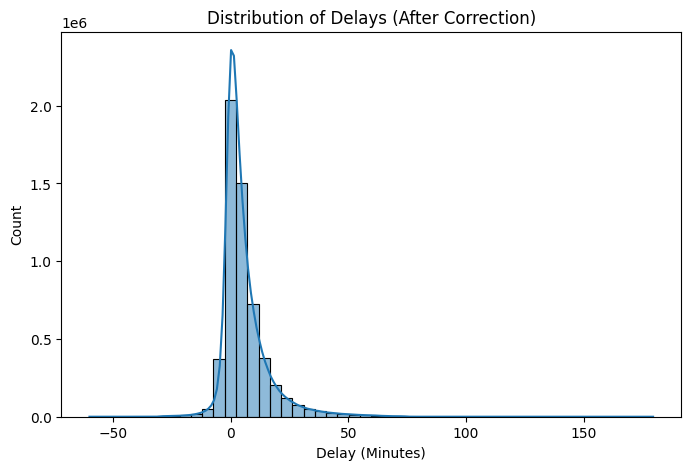

In [6]:
# Calculate delay in minutes
df['delay'] = (df['ExpectedArrivalTime'] - df['ScheduledArrivalTime']).dt.total_seconds() / 60

# Remove outliers (-60 to 180 minutes)
df = df[df['delay'].between(-60, 180)]

# Check the updated delay data
print("\nUpdated `delay` data after correction:")
print(df['delay'].describe())

# Visualize the distribution of delays
plt.figure(figsize=(8,5))
sns.histplot(df['delay'], bins=50, kde=True)
plt.title("Distribution of Delays (After Correction)")
plt.xlabel("Delay (Minutes)")
plt.ylabel("Count")
plt.show()

In [7]:
# Extract day of the week (0 = Monday, 6 = Sunday)
df['day_of_week'] = df['ExpectedArrivalTime'].dt.dayofweek

# Extract hour of the day (0-23)
df['hour'] = df['ExpectedArrivalTime'].dt.hour

# Define rush hour flag (1 = morning/evening peak, 0 = other times)
df['rush_hour'] = df['hour'].apply(lambda x: 1 if 7 <= x <= 9 or 16 <= x <= 19 else 0)

# Calculate average delay per route
df['avg_route_delay'] = df.groupby('PublishedLineName')['delay'].transform('mean')

In [8]:
# Function to calculate Haversine distance
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in km
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    a = np.sin(dlat / 2.0) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    
    return R * c  # Return distance in km

# Calculate trip distance for all rows
df['trip_distance'] = haversine(df['OriginLat'].values, df['OriginLong'].values, 
                                df['DestinationLat'].values, df['DestinationLong'].values)

# Verify that distances are calculated
print("\n`trip_distance` added successfully!")
print(df[['OriginLat', 'OriginLong', 'DestinationLat', 'DestinationLong', 'trip_distance']].head())


`trip_distance` added successfully!
     OriginLat  OriginLong  DestinationLat  DestinationLong  trip_distance
129  40.717762  -73.735481       40.706795       -73.804100       5.910729
138  40.818676  -73.851555       40.849033       -73.937309       7.965199
181  40.643429  -74.073654       40.601971       -74.191330      10.949403
182  40.643429  -74.073654       40.601971       -74.191330      10.949403
242  40.642979  -73.878334       40.576973       -73.981400      11.382589


In [9]:
# Remove unnecessary columns
df = df.drop(columns=['RecordedAtTime', 'DirectionRef', 'OriginName', 'DestinationName', 
                      'VehicleRef', 'DistanceFromStop', 'ExpectedArrivalTime', 
                      'ScheduledArrivalTime', 'ScheduledDate'])

print(df.columns)

Index(['PublishedLineName', 'OriginLat', 'OriginLong', 'DestinationLat',
       'DestinationLong', 'VehicleLocation.Latitude',
       'VehicleLocation.Longitude', 'NextStopPointName',
       'ArrivalProximityText', 'delay', 'day_of_week', 'hour', 'rush_hour',
       'avg_route_delay', 'trip_distance'],
      dtype='object')


In [10]:
# Select features for modeling
features = ['PublishedLineName', 'day_of_week', 'hour', 'rush_hour', 
            'trip_distance', 'avg_route_delay', 'OriginLat', 'OriginLong', 
            'DestinationLat', 'DestinationLong']
X = df[features]
y = df['delay']

# Encode categorical variable (route number)
encoder = LabelEncoder()
X['PublishedLineName'] = encoder.fit_transform(X['PublishedLineName'])

# Normalize numerical features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y.values.reshape(-1, 1))

# Split into train/test sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

<ipython-input-10-bc8bb4954362>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['PublishedLineName'] = encoder.fit_transform(X['PublishedLineName'])


Baseline (Historical Mean) MAE: 6.54 minutes
Baseline (Historical Mean) RMSE: 9.74 minutes


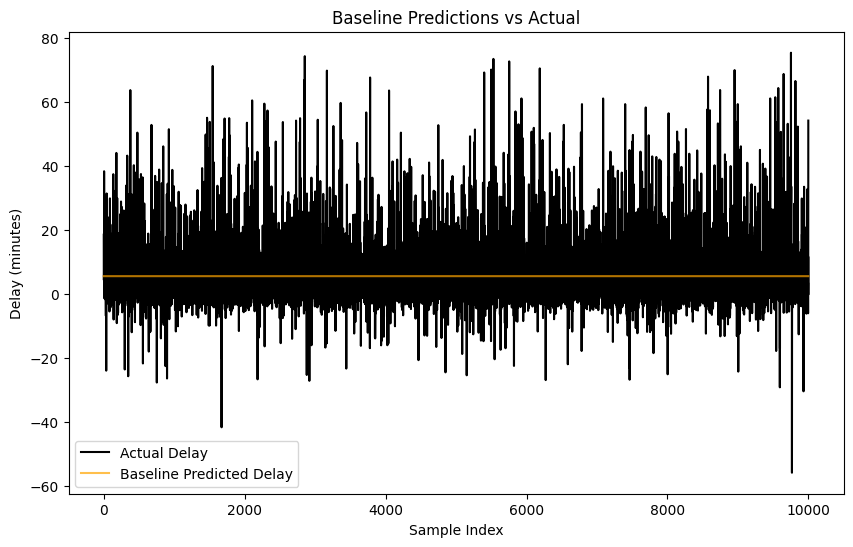

In [21]:
# Baseline (Historical Mean) Model
historical_mean_delay = y_train.mean()
y_pred_baseline = np.full_like(y_test, fill_value=historical_mean_delay)

# Denormalize baseline predictions
y_pred_baseline_denorm = scaler_y.inverse_transform(y_pred_baseline.reshape(-1, 1))

# Evaluate baseline model
mae_baseline = mean_absolute_error(y_test_denorm, y_pred_baseline_denorm)
rmse_baseline = np.sqrt(mean_squared_error(y_test_denorm, y_pred_baseline_denorm))
print(f"Baseline (Historical Mean) MAE: {mae_baseline:.2f} minutes")
print(f"Baseline (Historical Mean) RMSE: {rmse_baseline:.2f} minutes")

# Plot baseline predictions
plt.figure(figsize=(10, 6))
plt.plot(y_test_denorm, label='Actual Delay', color='black')
plt.plot(y_pred_baseline_denorm, label='Baseline Predicted Delay', alpha=0.7, color='orange')
plt.title('Baseline Predictions vs Actual')
plt.xlabel('Sample Index')
plt.ylabel('Delay (minutes)')
plt.legend()
plt.show()


Model Results (Linear Regression):
MAE: 6.27 minutes
RMSE: 9.40 minutes


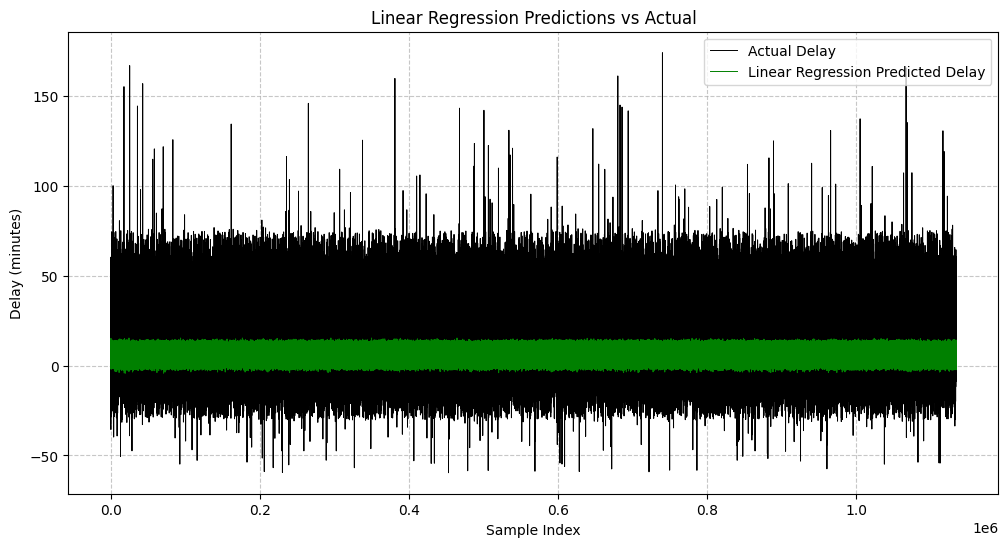

In [11]:
# Train a Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Make predictions
y_pred_lr = lr_model.predict(X_test)

# Denormalize predictions
y_pred_lr_denorm = scaler.inverse_transform(y_pred_lr.reshape(-1, 1)).flatten()
y_test_denorm = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Evaluate the model
mae_lr = mean_absolute_error(y_test_denorm, y_pred_lr_denorm)
rmse_lr = np.sqrt(mean_squared_error(y_test_denorm, y_pred_lr_denorm))

print("\nModel Results (Linear Regression):")
print(f"MAE: {mae_lr:.2f} minutes")
print(f"RMSE: {rmse_lr:.2f} minutes")

plt.figure(figsize=(12, 6))
plt.plot(y_test_denorm, color='black', label='Actual Delay', linewidth=0.7)
plt.plot(y_pred_lr_denorm, color='green', label='Linear Regression Predicted Delay', linewidth=0.7)
plt.title('Linear Regression Predictions vs Actual')
plt.xlabel('Sample Index')
plt.ylabel('Delay (minutes)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


Epoch 1/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0095 - val_loss: 0.0015
Epoch 2/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0019 - val_loss: 0.0015
Epoch 3/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0018 - val_loss: 0.0015
Epoch 4/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 5/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 6/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 7/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 8/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 9/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 10/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0015 - val_loss: 0.0015
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
LSTM MAE: 6.41 minutes
LSTM RMSE: 9.27 minutes


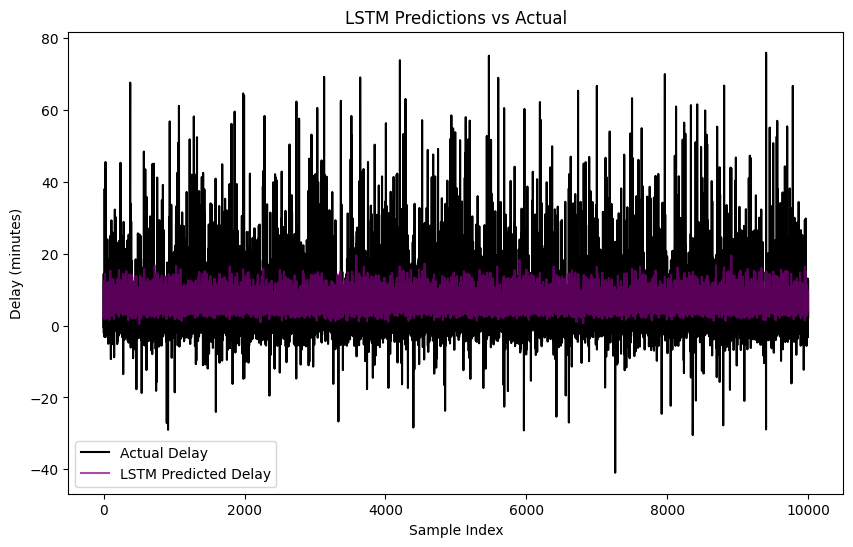

In [16]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam

# Data preparation
features = ['PublishedLineName', 'day_of_week', 'hour', 'rush_hour', 
            'trip_distance', 'avg_route_delay', 'OriginLat', 'OriginLong', 
            'DestinationLat', 'DestinationLong']
X = df[features]
y = df['delay']

# Encode time cyclically using sine and cosine transformations
X = X.copy()
X.loc[:, 'hour_sin'] = np.sin(2 * np.pi * X['hour'] / 24)
X.loc[:, 'hour_cos'] = np.cos(2 * np.pi * X['hour'] / 24)

# Encode categorical feature 'PublishedLineName'
X.loc[:, 'PublishedLineName'] = LabelEncoder().fit_transform(X['PublishedLineName'])

# Normalize features and target
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# Take a small sample of the data for faster training
sample_size = 50000
indices = np.random.choice(len(X_scaled), sample_size, replace=False)
X_sampled = X_scaled[indices]
y_sampled = y_scaled[indices]

# Reshape the data for LSTM (samples, time steps, features)
time_steps = 1
X_sampled = X_sampled.reshape((X_sampled.shape[0], time_steps, X_sampled.shape[1]))

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_sampled, y_sampled, test_size=0.2, random_state=42, shuffle=False)

# Build LSTM model
model = Sequential([
    Input(shape=(time_steps, X_train.shape[2])),
    LSTM(units=64, return_sequences=True),
    Dropout(0.2),
    LSTM(units=32, return_sequences=False),
    Dropout(0.2),
    Dense(units=1)
])

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.1, verbose=1)

# Make predictions
y_pred = model.predict(X_test)

# Denormalize predictions and actual values
y_pred_denorm = scaler_y.inverse_transform(y_pred)
y_test_denorm = scaler_y.inverse_transform(y_test)

# Evaluate the model
mae_lstm = mean_absolute_error(y_test_denorm, y_pred_denorm)
rmse_lstm = np.sqrt(mean_squared_error(y_test_denorm, y_pred_denorm))
print(f"LSTM MAE: {mae_lstm:.2f} minutes")
print(f"LSTM RMSE: {rmse_lstm:.2f} minutes")

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_denorm, label='Actual Delay', color='black')
plt.plot(y_pred_denorm, label='LSTM Predicted Delay', alpha=0.7, color='purple')
plt.title('LSTM Predictions vs Actual')
plt.xlabel('Sample Index')
plt.ylabel('Delay (minutes)')
plt.legend()
plt.show()


RandomForest MAE: 6.19 minutes
RandomForest RMSE: 9.29 minutes


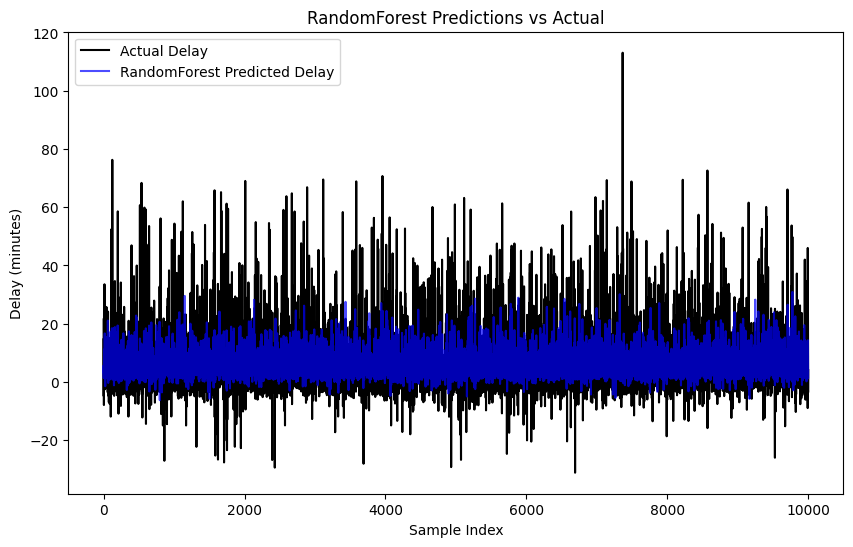

In [14]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Data preparation
features = ['PublishedLineName', 'day_of_week', 'hour', 'rush_hour', 
            'trip_distance', 'avg_route_delay', 'OriginLat', 'OriginLong', 
            'DestinationLat', 'DestinationLong']
X = df[features]
y = df['delay']

# Encode time cyclically using sine and cosine transformations
X = X.copy()
X.loc[:, 'hour_sin'] = np.sin(2 * np.pi * X['hour'] / 24)
X.loc[:, 'hour_cos'] = np.cos(2 * np.pi * X['hour'] / 24)

# Encode categorical feature 'PublishedLineName'
X.loc[:, 'PublishedLineName'] = LabelEncoder().fit_transform(X['PublishedLineName'])

# Normalize features and target
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# Take a random sample of the data to speed up computation
sample_size = 50000  # e.g., 50000 rows
indices = np.random.choice(len(X_scaled), sample_size, replace=False)
X_sampled = X_scaled[indices]
y_sampled = y_scaled[indices]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_sampled, y_sampled, test_size=0.2, random_state=42, shuffle=False)

# Flatten target arrays to 1D for RandomForest compatibility
y_train = y_train.ravel()
y_test = y_test.ravel()

# Build RandomForest model
rf_model = RandomForestRegressor(
    n_estimators=500,
    max_depth=12,
    min_samples_split=5,
    min_samples_leaf=3,
    random_state=42,
    n_jobs=-1
)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Denormalize predictions and actual values
y_pred_denorm = scaler_y.inverse_transform(y_pred.reshape(-1, 1))
y_test_denorm = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# Evaluate the model
mae_rf = mean_absolute_error(y_test_denorm, y_pred_denorm)
rmse_rf = np.sqrt(mean_squared_error(y_test_denorm, y_pred_denorm))
print(f"RandomForest MAE: {mae_rf:.2f} minutes")
print(f"RandomForest RMSE: {rmse_rf:.2f} minutes")

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_denorm, label='Actual Delay', color='black')
plt.plot(y_pred_denorm, label='RandomForest Predicted Delay', alpha=0.7, color='blue')
plt.title('RandomForest Predictions vs Actual')
plt.xlabel('Sample Index')
plt.ylabel('Delay (minutes)')
plt.legend()
plt.show()

Gradient Boosting MAE: 6.15 minutes
Gradient Boosting RMSE: 9.22 minutes


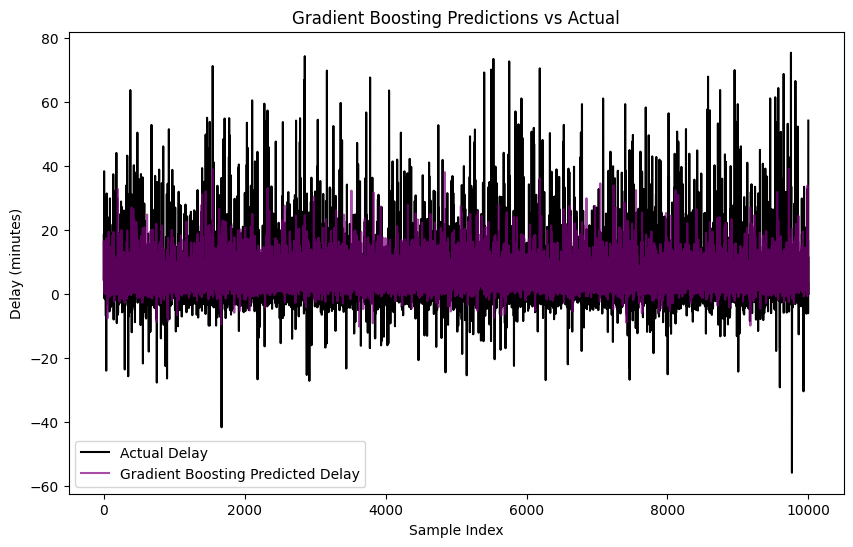

In [19]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor

# Data preparation
features = ['PublishedLineName', 'day_of_week', 'hour', 'rush_hour', 
            'trip_distance', 'avg_route_delay', 'OriginLat', 'OriginLong', 
            'DestinationLat', 'DestinationLong']
X = df[features]
y = df['delay']

# Encode time cyclically using sine and cosine transformations
X = X.copy()
X.loc[:, 'hour_sin'] = np.sin(2 * np.pi * X['hour'] / 24)
X.loc[:, 'hour_cos'] = np.cos(2 * np.pi * X['hour'] / 24)

# Encode categorical feature 'PublishedLineName'
X.loc[:, 'PublishedLineName'] = LabelEncoder().fit_transform(X['PublishedLineName'])

# Normalize features and target
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# Take a small sample of the data for faster training
sample_size = 50000
indices = np.random.choice(len(X_scaled), sample_size, replace=False)
X_sampled = X_scaled[indices]
y_sampled = y_scaled[indices]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_sampled, y_sampled, test_size=0.2, random_state=42, shuffle=False)

# Flatten target arrays to 1D for Gradient Boosting compatibility
y_train = y_train.ravel()
y_test = y_test.ravel()

# Build Gradient Boosting model
gb_model = GradientBoostingRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=8,
    min_samples_split=5,
    min_samples_leaf=3,
    random_state=42
)

# Train the model
gb_model.fit(X_train, y_train)

# Make predictions
y_pred = gb_model.predict(X_test)

# Denormalize predictions and actual values
y_pred_denorm = scaler_y.inverse_transform(y_pred.reshape(-1, 1))
y_test_denorm = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# Evaluate the model
mae_gb = mean_absolute_error(y_test_denorm, y_pred_denorm)
rmse_gb = np.sqrt(mean_squared_error(y_test_denorm, y_pred_denorm))
print(f"Gradient Boosting MAE: {mae_gb:.2f} minutes")
print(f"Gradient Boosting RMSE: {rmse_gb:.2f} minutes")

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_denorm, label='Actual Delay', color='black')
plt.plot(y_pred_denorm, label='Gradient Boosting Predicted Delay', alpha=0.7, color='purple')
plt.title('Gradient Boosting Predictions vs Actual')
plt.xlabel('Sample Index')
plt.ylabel('Delay (minutes)')
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:0.04170
[1]	validation_0-rmse:0.04158
[2]	validation_0-rmse:0.04146
[3]	validation_0-rmse:0.04138
[4]	validation_0-rmse:0.04128
[5]	validation_0-rmse:0.04117
[6]	validation_0-rmse:0.04108
[7]	validation_0-rmse:0.04099
[8]	validation_0-rmse:0.04091
[9]	validation_0-rmse:0.04084
[10]	validation_0-rmse:0.04076
[11]	validation_0-rmse:0.04071
[12]	validation_0-rmse:0.04064
[13]	validation_0-rmse:0.04057
[14]	validation_0-rmse:0.04053
[15]	validation_0-rmse:0.04048
[16]	validation_0-rmse:0.04044
[17]	validation_0-rmse:0.04038
[18]	validation_0-rmse:0.04033
[19]	validation_0-rmse:0.04027
[20]	validation_0-rmse:0.04022
[21]	validation_0-rmse:0.04018
[22]	validation_0-rmse:0.04014
[23]	validation_0-rmse:0.04010
[24]	validation_0-rmse:0.04006
[25]	validation_0-rmse:0.04003
[26]	validation_0-rmse:0.03999
[27]	validation_0-rmse:0.03997
[28]	validation_0-rmse:0.03994
[29]	validation_0-rmse:0.03991
[30]	validation_0-rmse:0.03988
[31]	validation_0-rmse:0.03985
[32]	validation_0-

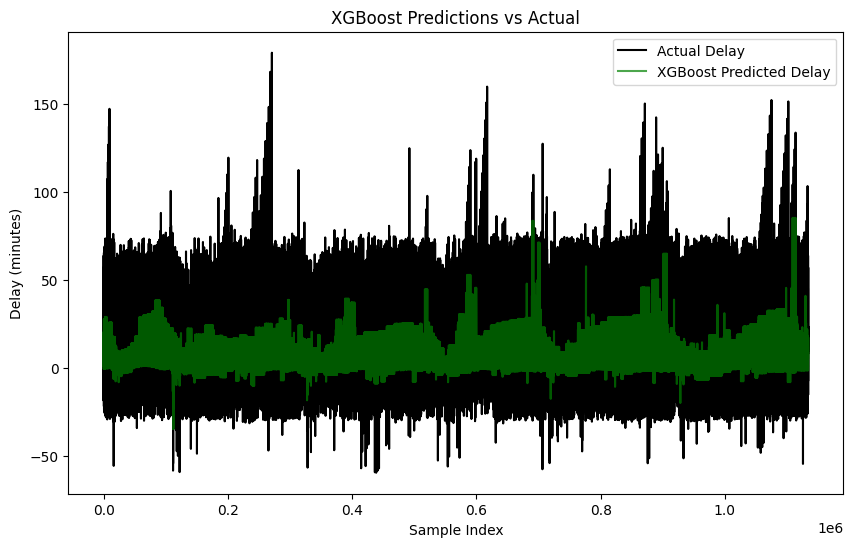

In [13]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Data preparation
features = ['PublishedLineName', 'day_of_week', 'hour', 'rush_hour', 
            'trip_distance', 'avg_route_delay', 'OriginLat', 'OriginLong', 
            'DestinationLat', 'DestinationLong']
X = df[features]
y = df['delay']

# Encode time cyclically using sine and cosine transformations
X = X.copy()
X.loc[:, 'hour_sin'] = np.sin(2 * np.pi * X['hour'] / 24)
X.loc[:, 'hour_cos'] = np.cos(2 * np.pi * X['hour'] / 24)

# Encode categorical feature 'PublishedLineName'
X.loc[:, 'PublishedLineName'] = LabelEncoder().fit_transform(X['PublishedLineName'])

# Normalize features and target
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42, shuffle=False)

# Flatten target arrays to 1D for XGBoost compatibility
y_train = y_train.ravel()
y_test = y_test.ravel()

# Build XGBoost model
xgb_model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.03,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    random_state=42
)

# Train the model with early stopping
xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=20, verbose=True)

# Make predictions
y_pred = xgb_model.predict(X_test)

# Denormalize predictions and actual values
y_pred_denorm = scaler_y.inverse_transform(y_pred.reshape(-1, 1))
y_test_denorm = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# Evaluate the model
mae_xgb = mean_absolute_error(y_test_denorm, y_pred_denorm)
rmse_xgb = np.sqrt(mean_squared_error(y_test_denorm, y_pred_denorm))
print(f"XGBoost MAE: {mae_xgb:.2f} minutes")
print(f"XGBoost RMSE: {rmse_xgb:.2f} minutes")

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_denorm, label='Actual Delay', color='black')
plt.plot(y_pred_denorm, label='XGBoost Predicted Delay', alpha=0.7, color='green')
plt.title('XGBoost Predictions vs Actual')
plt.xlabel('Sample Index')
plt.ylabel('Delay (minutes)')
plt.legend()
plt.show()

In [28]:
results_df = pd.DataFrame({
    'Model': [
        'Baseline (Mean)', 
        'Linear Regression', 
        'XGBoost', 
        'Gradient Boosting', 
        'LSTM', 
        'Random Forest'
    ],
    'MAE': [
        mae_baseline, 
        mae_lr, 
        mae_xgb, 
        mae_gb, 
        mae_lstm, 
        mae_rf
    ],
    'RMSE': [
        rmse_baseline, 
        rmse_lr, 
        rmse_xgb, 
        rmse_gb, 
        rmse_lstm, 
        rmse_rf
    ]
})

print(results_df)

               Model       MAE      RMSE
0    Baseline (Mean)  6.600388  9.948147
1  Linear Regression  6.271740  9.397227
2            XGBoost  6.202034  9.443882
3  Gradient Boosting  6.149041  9.223561
4               LSTM  6.406764  9.273884
5      Random Forest  6.188157  9.285010
